### Network Symmetrization  

In [2]:
import networkx as nx
import numpy as np

In [3]:
def net_symmetrization(file:str, excluded_countries:list=[]):
    dg = nx.DiGraph()

    #These are the field positions in the data
    reporter_pos = 1
    partner_pos = 3
    flow_code_pos = 2
    value_pos = 9

    dic_trade_flows = {}
    hfile = open(file,'r')

    header = hfile.readline()
    lines = hfile.readlines()

    for l in lines:
        
        l_split = l.split(',')
        
        if len(l_split)<2: continue

        reporter = int(l_split[reporter_pos])
        partner = int(l_split[partner_pos])
        flow_code = int(l_split[flow_code_pos])
        value = float(l_split[value_pos])

        if reporter in excluded_countries or \
            partner in excluded_countries or \
                reporter == partner: continue

        if flow_code == 1 and value > 0:
            # 1=import and 2=export
            if (partner, reporter, 2) in dic_trade_flows:
                dg[partner][reporter]['weight'] = \
                    (dg[partner][reporter]['weight'] + value)/2
            else:
                dg.add_edge(partner, reporter, weight = value)
                dic_trade_flows[(partner, reporter, 1)] = value

        elif flow_code == 2 and value > 0:
            if (reporter, partner, 1) in dic_trade_flows:
                dg[reporter][partner]['weight'] = \
                    (dg[reporter][partner]['weight'] + value)/2
            else:
                dg.add_edge(reporter, partner, weight = value)
                dic_trade_flows[(reporter, partner, 2)] = value
        else: print('Trade flow no present\n')

    hfile.close()

    return dg

### Generate the aggregate network

In [41]:
excluded_countries = [472,899,471,129,221,97,697,492,838,473,536,637,290, \
                      527, 577, 490, 568, 636, 839, 879, 0]

In [42]:
dg = net_symmetrization("data/comtrade_trade_data_total_2003.csv", \
                        excluded_countries)
print(dg.number_of_nodes())
print(dg.number_of_edges())

232
27901


#### Test calculation of reciprocity

First I will create an adjacency matrix using numpy array, than use the `nx.from_numpy_array` to create the directed graph

In [7]:
A = np.array([[0,1,1,0], [0,0,0,1],[1,0,0,1],[1,1,0,0]])

In [8]:
test_dg=nx.from_numpy_array(A, create_using=nx.DiGraph)

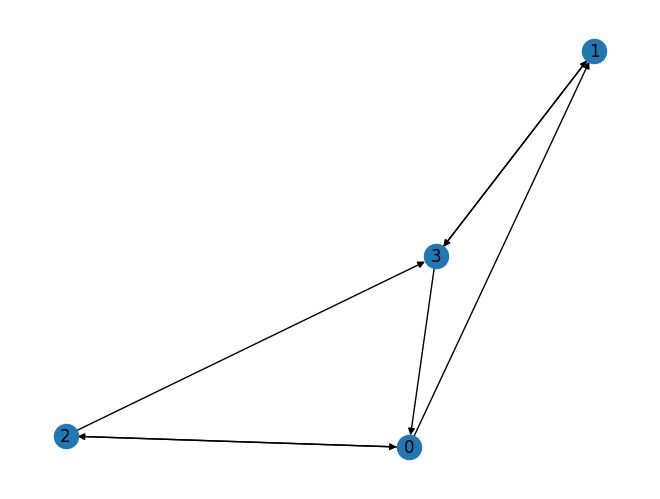

In [9]:
nx.draw(test_dg, with_labels=True)

The `nx.overall_reciprocity` calculates the reciprocity using:

$$r=\frac{L^{\longleftrightarrow}}{L}=\frac{1}{m}*TrA^2$$

however, you can use the following to determine the reciprocity and this is what the function does:

```
n_all_edge = G.number_of_edges()
n_overlap_edge = (n_all_edge - G.to_undirected().number_of_edges()) * 2
return n_overlap_edge / n_all_edge
```

This is clever, it takes all the edges and subtracts the number of edges if the directed graph is not directed. This will give you "(The number of reciprocal links)/2" so you need to multiply by two.

In [10]:
nx.overall_reciprocity(test_dg)

0.5714285714285714

In [11]:
4/7

0.5714285714285714

In [12]:
nx.degree_assortativity_coefficient(test_dg)

-0.16666666666667096

I believe these functions do the same thing...

In [13]:
nx.degree_assortativity_coefficient(dg)

-0.3335568300628826

In [14]:
nx.degree_pearson_correlation_coefficient(dg, weight='weight',x='out',y='in')

-0.06222859801835988

### Weighted Networks and Strength

In [15]:
dic_product_networks = {}

commodity_codes = ['09','10','27','29','30','39','52','71','72','84','85','87','90','93']

In [16]:
# makes graphs for each product, vertices are countries, links are weighted by value of trade
for c in commodity_codes:
    dic_product_networks[c] = net_symmetrization('./data/comtrade_trade_data_2003_product_'+c+'.csv', excluded_countries)

In [21]:
dg_aggregate = net_symmetrization("./data/comtrade_trade_data_total_2003.csv", excluded_countries)

In [43]:
w_tot=0.0
for u,v,d  in dg_aggregate.edges(data=True):
    w_tot+=d['weight']
for u,v,d  in dg_aggregate.edges(data=True):
    d['weight']=d['weight']/w_tot

In [45]:
for c in commodity_codes:
    w_tot=0.0
    for u,v,d  in dic_product_networks[c].edges(data=True):
        w_tot+=d['weight']
    for u,v,d  in dic_product_networks[c].edges(data=True):
        d['weight']=d['weight']/w_tot

In [47]:
density_aggregate=dg_aggregate.number_of_edges() / \
(dg_aggregate.number_of_nodes()*(dg_aggregate.number_of_nodes()-1.0))

w_agg=[]
ns_in=[]
ns_out=[]
for u,v,d in dg_aggregate.edges(data=True):
    w_agg.append(d['weight'])
for n in dg_aggregate.nodes():
    if dg_aggregate.in_degree(n)>0:
        ns_in.append(dg_aggregate.in_degree(n,weight='weight')/ \
                     dg_aggregate.in_degree(n))
    if dg_aggregate.out_degree(n)>0:
        ns_out.append(dg_aggregate.out_degree(n,weight='weight')/ \
                      dg_aggregate.out_degree(n))
    
for c in commodity_codes:
    density_commodity=dic_product_networks[c].number_of_edges() / \
    (dic_product_networks[c].number_of_nodes()* \
    (dic_product_networks[c].number_of_nodes()-1.0))
    w_c=[]
    NS_c_in=[]
    NS_c_out=[]
    for u,v,d  in dic_product_networks[c].edges(data=True):
        w_c.append(d['weight'])
    for n in dic_product_networks[c].nodes():
        if dic_product_networks[c].in_degree(n)>0:
            NS_c_in.append(dic_product_networks[c].in_degree (n, \
            weight='weight')/dic_product_networks[c].in_degree(n))
        if dic_product_networks[c].out_degree(n)>0:
            NS_c_out.append(dic_product_networks[c].out_degree(n, \
            weight='weight')/dic_product_networks[c].out_degree(n))

    print(c,str(round(density_commodity/density_aggregate,4))+ \
    " & "+str(round(mean(w_c)/mean(w_agg),4))+" & "+ \
    str(round(mean(NS_c_in)/mean(ns_in),4))+" & "+ \
    str(round(mean(NS_c_out)/mean(ns_out),4)))

09 0.3111 & 3.3572 & 2.5315 & 2.3736
10 0.1983 & 5.4569 & 5.9085 & 2.5459
27 0.3091 & 3.3208 & 2.6534 & 3.2754
29 0.3121 & 3.3461 & 2.3415 & 1.6181
30 0.368 & 2.789 & 2.3117 & 1.2546
39 0.4943 & 2.0406 & 1.7389 & 1.1325
52 0.2882 & 3.5609 & 2.7299 & 2.1028
71 0.2865 & 3.6452 & 1.9726 & 2.6578
72 0.3102 & 3.3087 & 2.5585 & 1.8352
84 0.6202 & 1.6263 & 1.3266 & 1.0207
85 0.5973 & 1.6886 & 1.3432 & 1.0648
87 0.4486 & 2.2485 & 1.7365 & 1.1052
90 0.475 & 2.1419 & 1.5751 & 1.0934
93 0.1431 & 8.3627 & 6.0933 & 3.9946
